## Imports

In [1]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,balanced_accuracy_score
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
import requests
import random
import joblib
np.set_printoptions(threshold=np.inf)

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df.drop(columns=['Unnamed: 0'],inplace=True)

## Main objective of the model

We want to give consistent predictions to the Toyota team.

We want to be sure that when we will tell them they will win, it will effectively happen. 

It means the main objective of our model is to maximize the precision for predicting the positive class, corresponding to victories.

## Encode the text columns to categories columns

### General columns

In [4]:
label_encoder = LabelEncoder()

In [5]:
to_encode = ['vehicle', 'race', 'Competitor1',
       'Competitor1_Vehicle','Competitor2', 'Competitor2_Vehicle','season',
       'Environment', 'Difficulty of Turning','Most Useful Attribute', 'Second Most Useful Attribute',
       'Rain during the Race']

In [6]:
for column in to_encode:
    df[column] = label_encoder.fit_transform(df[column])

### Encode Drivers columns that need to have the same codes for the same driver across the columns

In [7]:
# Combine all values to encode
unique_values = pd.concat([df['driver_1'], df['driver_2'], df['driver_3']]).unique()

# Adapt the label_encoder
label_encoder.fit(unique_values)

# Encode the columns
df['driver_1'] = label_encoder.transform(df['driver_1'])
df['driver_2'] = label_encoder.transform(df['driver_2'])
df['driver_3'] = label_encoder.transform(df['driver_3'])

### Enconding Result: make it consistent

To be accurate and consistent, let's put a Victory as 1, and a defeat as 0.

When someones will see the model for the first, his reflex will be to link 1 to a victory, and 0 to a defeat.

In [8]:
def result_into_num(a):
    if a=="Victory":
        return 1
    else:
        return 0

In [9]:
df['Result'] = df['Result'].apply(result_into_num)

In [10]:
df['Result'].value_counts()

Result
1    42
0    38
Name: count, dtype: int64

## Features Engineering 3 : Differentials

We already made a Features Engineering process in the Process part, by adding information about the race conditions, tracks and car characteristics.

Let's be more precise by linking the specifications of the cars that can be linked together.

For instance, speeds can compared using differentials. Same thing for best times.

### Calculate differentials of speed and best lap times

In [11]:
df['Max_Speed_Gap_Vs_Competitor_1'] = df['fl_kph_average'] - df['Competitor1_Best_Speed']
df['Max_Speed_Gap_Vs_Competitor_2'] = df['fl_kph_average'] - df['Competitor2_Best_Speed']

In [12]:
df['fl_time'] = pd.to_timedelta(df['fl_time'])
df['Competitor1_Best_Time'] = pd.to_timedelta(df['Competitor1_Best_Time'])
df['Competitor2_Best_Time'] = pd.to_timedelta(df['Competitor2_Best_Time'])

In [13]:
df['Min_Time_Gap_Vs_Competitor_1'] = df['fl_time'] - df['Competitor1_Best_Time']
df['Min_Time_Gap_Vs_Competitor_2'] = df['fl_time'] - df['Competitor2_Best_Time']

### Remove the times and average speeds columns

In [14]:
df.drop(columns=['fl_time','fl_kph_average','Competitor2_Best_Time','Competitor1_Best_Speed','Competitor1_Best_Time','Competitor2_Best_Speed'],inplace=True)

In [15]:
df

,vehicle,race,event_duration,season,driver_1,driver_2,driver_3,Competitor1,Competitor1_Vehicle,Competitor2,...,Difficulty of Turning,Straight Length,Most Useful Attribute,Second Most Useful Attribute,Rain during the Race,Result,Max_Speed_Gap_Vs_Competitor_1,Max_Speed_Gap_Vs_Competitor_2,Min_Time_Gap_Vs_Competitor_1,Min_Time_Gap_Vs_Competitor_2
0,0,0,8,9,10,6,2,0,0,5,...,2,0.8,4,1,0,1,-0.1,2.9,0 days 00:00:00.087000,-1 days +23:59:58.555000
1,0,0,6,11,10,2,9,2,3,8,...,2,0.8,4,1,1,1,0.1,1.8,-1 days +23:59:59.926000,-1 days +23:59:59.074000
2,1,1,6,0,0,8,12,1,1,1,...,1,1.2,0,2,0,0,0.3,0.1,-1 days +23:59:59.854000,-1 days +23:59:59.988000
3,1,1,6,1,1,10,11,1,1,1,...,1,1.2,0,2,0,1,-0.2,0.6,0 days 00:00:00.140000,-1 days +23:59:59.667000
4,2,1,6,2,0,11,7,4,5,8,...,1,1.2,0,2,0,1,-0.3,0.1,0 days 00:00:00.220000,-1 days +23:59:59.989000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,3,12,6,7,10,6,3,5,7,10,...,0,1.0,2,3,1,1,2.4,2.6,-1 days +23:59:58.663000,-1 days +23:59:58.582000
76,3,12,6,8,7,5,4,5,7,2,...,0,1.0,2,3,1,1,-0.1,4.7,0 days 00:00:00.085000,-1 days +23:59:57.195000
77,0,12,6,9,10,6,2,0,0,0,...,0,1.0,2,3,0,1,1.5,1.5,-1 days +23:59:59.108000,-1 days +23:59:59.108000
78,0,12,6,10,7,5,4,0,0,5,...,0,1.0,2,3,1,1,0.7,-0.3,-1 days +23:59:59.573000,0 days 00:00:00.176000


### Convert the timedelta into number of seconds

Timedelta format won't be recognized in the calculation.

In [16]:
df['Min_Time_Gap_Vs_Competitor_1'] = df['Min_Time_Gap_Vs_Competitor_1'].dt.total_seconds()

In [17]:
df['Min_Time_Gap_Vs_Competitor_2'] = df['Min_Time_Gap_Vs_Competitor_2'].dt.total_seconds()

## Split into train & test sets

In [18]:
X=df.drop(columns=['Result'])
y=df['Result']

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)

## First model : RandomForest

In [20]:
rdf = RandomForestClassifier(n_estimators=300, 
                             max_depth=20,
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_features='auto',
                             random_state=42)

In [21]:
rdf.fit(X_train,y_train)

C:\Users\sdhuart\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=20, max_features='auto', n_estimators=300,
                       random_state=42)

In [22]:
y_pred = rdf.predict(X_test)

### Results

In [23]:
print('Classification report:\n', classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.80      0.80      0.80        10

    accuracy                           0.75        16
   macro avg       0.73      0.73      0.73        16
weighted avg       0.75      0.75      0.75        16



When the model predicts a victory, it is correct 80% of the time.
The performance for defeats is lower.

The model also identifies correctly 80% of the victories and 67% of the defeats.

This first instance is satisfying. 

We will go to the next step, trying to improve again the performance.

### Finetuning hyperparameters

In [24]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of decision trees
    'max_depth': [None, 10, 20, 30, 40, 50],  # Max Depth of a tree
    'min_samples_split': [2, 5, 10],  # Min number of samples to divide
    'min_samples_leaf': [1, 2, 4],  # Min number of samples in a leaf
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of characteristics to consider
    'bootstrap': [True, False]  # Sampling method
}

In [25]:
grid_search = GridSearchCV(estimator=rdf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

In [26]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


C:\Users\sdhuart\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=20, max_features='auto',
                                              n_estimators=300,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=2)

### Results

In [27]:
grid_search.best_score_

0.7807692307692308

In [28]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [29]:
y_pred = grid_search.predict(X_test)

The 2 most important metrics are accuracy and f1_score.
Accuracy allows us to know if the model can categorize correctly.
F1 Score gives us the balance between precision and recall.

In [30]:
accuracy_score(y_test,y_pred)

0.75

In [31]:
f1_score(y_test,y_pred)

0.8000000000000002

In [32]:
print('Classification report:\n', classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.80      0.80      0.80        10

    accuracy                           0.75        16
   macro avg       0.73      0.73      0.73        16
weighted avg       0.75      0.75      0.75        16



In our case, it is more important to maximize precision.
We do not want to announce to Toyota leaders that their car will win to finally be wrong.

Looks like an interesting model.
Accuracy is higher equal to 75% and F1 Score higher than 80%.

We should try to improve it.

### Select the most important features only

In [33]:
importances = rdf.feature_importances_

In [34]:
#Make it correspond with the train set columns
feature_names = X_train.columns
feature_importances = pd.Series(importances, index=feature_names)

In [35]:
#Rank it from the most predictive to the least predictive
feature_importances = feature_importances.sort_values(ascending=False)

#### Add a visualisation

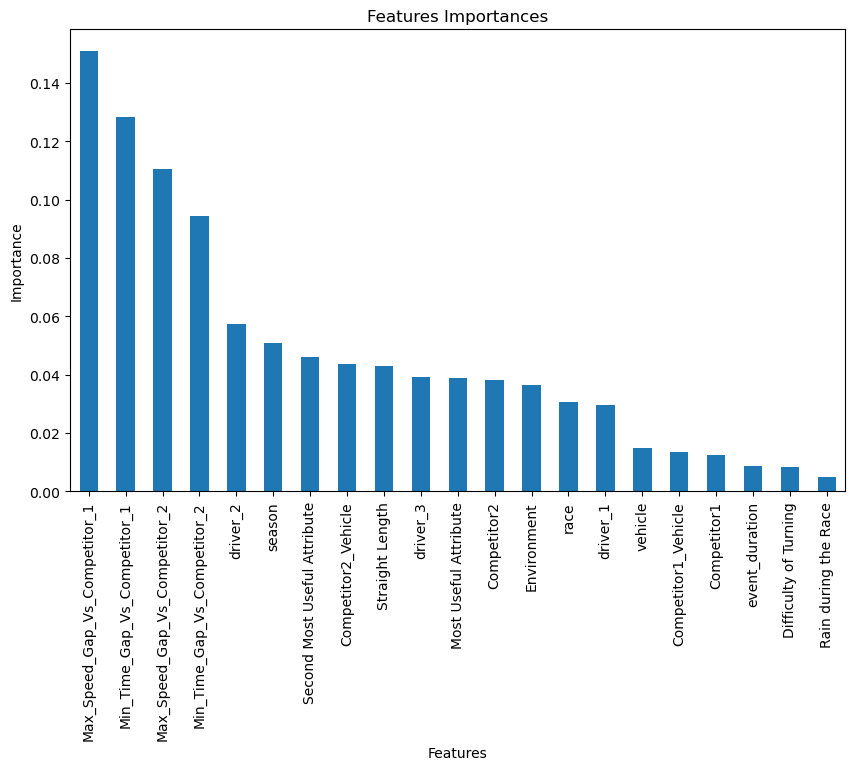

In [36]:
# Plotting the feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Features Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

### Conclusion

- The rain does not affect Toyota's performance. Toyota team is perfectly able to adapt to rainy conditions.
- The difficulty of turning does not affect the performance either. Toyota has good drivers who can adapt to different tracks. The car is also versatile.
- The race can last for 6, 12 or 24 hours, it won't determine the output. Toyota's car can perform on every type of race.
- The vehicles too do not seem to influence the performance that much. The main assumption is the name of the vehicle is surely highly correlated to the speed, gap in time and other indicators of performance.

### Check correlation between features

In [37]:
correlation = df.corr()

<Axes: >

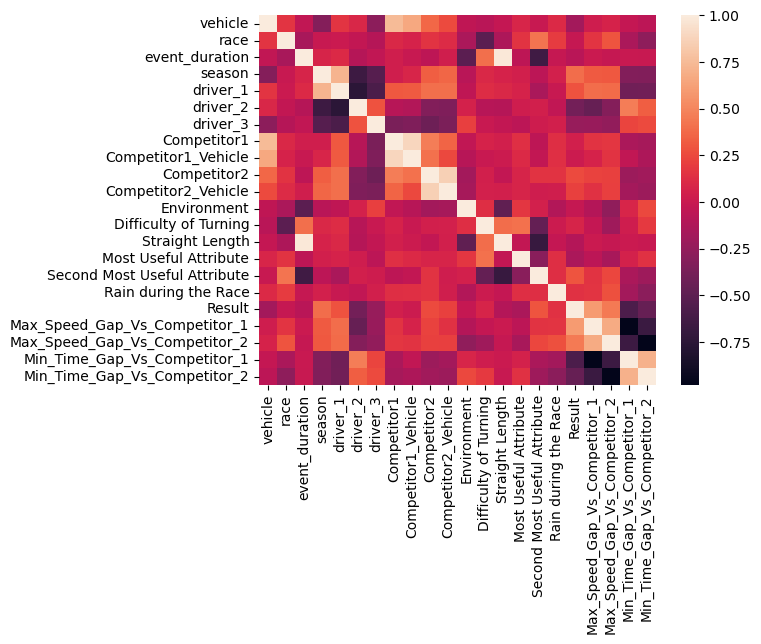

In [38]:
sns.heatmap(correlation)

## PCA

It seems we have some low-predicting features and correlation between features in our dataset.

We will use a PCA to correct our features, reduce the dimensionality and avoid having too many features correlated features.

In [39]:
# Standardize the data in the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [40]:
# Apply PCA to the training set
pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train_scaled)

In [41]:
# Do the same for the test set
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled) 

### Prediction using the new sets

In [42]:
rdf.fit(X_train_pca, y_train)

C:\Users\sdhuart\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=20, max_features='auto', n_estimators=300,
                       random_state=42)

In [43]:
y_pred_pca = rdf.predict(X_test_pca)

In [44]:
accuracy_score(y_test, y_pred_pca)

0.75

In [45]:
f1_score(y_test, y_pred_pca, average='weighted')

0.7500000000000001

In [46]:
print('Classification report:\n', classification_report(y_test, y_pred_pca))

Classification report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.80      0.80      0.80        10

    accuracy                           0.75        16
   macro avg       0.73      0.73      0.73        16
weighted avg       0.75      0.75      0.75        16



It seems the PCA has not improved our performance.

We will train other models to check if we can get better indicators in terms of accuracy, precision and recall.

## Second model : xgBoost

In [47]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)

### Training with standard sets

We start by training the model with the initial X_train training set.

In [48]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [49]:
y_pred = xgb_clf.predict(X_test)

In [50]:
accuracy_score(y_test, y_pred)

0.625

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.75      0.60      0.67        10

    accuracy                           0.62        16
   macro avg       0.62      0.63      0.62        16
weighted avg       0.66      0.62      0.63        16



The performance is not good, even though we predict correctly 75% of the victories, which goes well with the objective of the model.

### Training with PCA sets

In [52]:
xgb_clf.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [53]:
y_pred_pca = xgb_clf.predict(X_test_pca)

In [54]:
accuracy_score(y_test, y_pred_pca)

0.8125

In [55]:
print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.89      0.80      0.84        10

    accuracy                           0.81        16
   macro avg       0.80      0.82      0.81        16
weighted avg       0.82      0.81      0.81        16



Looks like this instance of xgBoost with PCA-processed sets is more performant. It is the best model so far.

89% of the predicted victories are indeed victories.

We can also identify 83% of the defeats and 80% of the victories. It is well balanced in terms of correct predictions.

In order to be sure, we will test a last model.

## Third model : SVC

In [56]:
svc = SVC(kernel='linear')

### Training with standard sets

In [57]:
svc.fit(X_train, y_train)

SVC(kernel='linear')

In [58]:
y_pred = svc.predict(X_test)

In [59]:
accuracy_score(y_test, y_pred)

0.875

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.83      1.00      0.91        10

    accuracy                           0.88        16
   macro avg       0.92      0.83      0.85        16
weighted avg       0.90      0.88      0.87        16



This model has the best accuracy score. It can identify 100% of the victories, even though it is also predicting victories when the real results are defeats.

The main issue is we lost performance in terms of precision compared to the second instance of xgBoost.

Let's see if we can improve the performance by training it on sets standardized and with a lower number of features.

### Training with PCA sets

In [61]:
svc.fit(X_train_pca, y_train)

SVC(kernel='linear')

In [62]:
y_pred_pca = svc.predict(X_test_pca)

In [63]:
accuracy_score(y_test, y_pred_pca)

0.9375

In [64]:
print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.90      0.95        10

    accuracy                           0.94        16
   macro avg       0.93      0.95      0.94        16
weighted avg       0.95      0.94      0.94        16



100% of the predicted victories are indeed victories. 

This model is the one we wanted to generate. Let's keep it.

Overall, it's a really good model. The accuracy rate is equal to 93.75%.

The model continues to predict some wrong defeats, lowering the precision for the negative class and recall for the positive class.

It remains aligned with our business objective, so we will keep it.

## Export SVC as model

In [65]:
joblib.dump(svc, 'svc_model.pkl')

['svc_model.pkl']

## Export the PCA transformations

In [66]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [67]:
joblib.dump(pca, 'pca.pkl')

['pca.pkl']